# Portfolio Optimization using Modern Portfolio Theory

### 📊 Theoretical Overview

Modern Portfolio Theory (MPT) describes how to construct portfolios that maximize return for a given level of risk.  
It relies on two key inputs:  
- **Expected returns (μ)** — estimated from historical or forecasted data  
- **Covariance matrix (Σ)** — measures how assets move together  

Given portfolio weights $w$:

$$
E[R_p] = w^\top \mu, \quad 
\sigma_p = \sqrt{w^\top \Sigma w}
$$

The **efficient frontier** represents the set of portfolios with the best possible risk–return trade-offs.  
Common optimization goals include:

- **Global Minimum Variance (GMV):** minimize $w^\top \Sigma w$  
- **Max Sharpe (Tangency Portfolio):** maximize $\frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}$

In this notebook, we’ll estimate returns and covariances, solve for optimal weights, and visualize the **efficient frontier**, **GMV**, and **tangency portfolio**.

### Import Required Libraries

In [58]:
import yfinance as yf
import pandas as pd 
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

## Section 1: Define Tickers and Time Range

In [59]:
# Define Tickers and Time Range
tickers = ['SPY','QQQ','VXUS','GLD','BND']
end_date = datetime.today()
start_date = end_date - timedelta(days=365*5)  # Last 5 years
print(start_date, end_date)

2020-10-17 13:26:59.511741 2025-10-16 13:26:59.511741


## Section 2: Donwload Adjusted Close Prices

In [60]:
# Create an empty DataFrame to hold adjusted close prices
adj_close_df = pd.DataFrame()

# Download adjusted close prices for each ticker
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    adj_close_df[ticker] = data['Close']

# Display the first few rows of the DataFrame
adj_close_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,QQQ,VXUS,GLD,BND
Date,,,,,
2020-10-19,318.842468,275.263397,45.571518,178.389999,75.798660
2020-10-20,320.119720,275.855072,45.914745,179.250000,75.669487
2020-10-21,319.513763,275.641693,45.786037,180.600006,75.583305
2020-10-22,321.266357,275.631989,45.794617,178.830002,75.454102
2020-10-23,322.357147,276.175110,46.052029,178.639999,75.548859


## 📈 Section 3: Calculate Lognormal Returns

We use **logarithmic (log) returns** instead of simple percentage returns because they are *time-additive* and better suited for portfolio optimization and statistical analysis.

For each asset:

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

#### 🔍 Variable Definitions
- **$r_t$** — log return at time *t*  
- **$P_t$** — adjusted closing price on day *t*  
- **$P_{t-1}$** — adjusted closing price on the previous trading day  
- **$\ln$** — natural logarithm (base *e*)

#### 💡 Why Log Returns?
- They are **time-additive**, meaning multi-period returns can be summed:  
  $R_{1\rightarrow T} = r_1 + r_2 + \dots + r_T$
- They better approximate **normality** for statistical modeling.  
- They handle **large price changes** symmetrically (e.g., +50% and −50% are not equal in simple returns).

In this section, we’ll compute daily log returns for each asset to prepare for portfolio risk and return analysis.

In [61]:
#Calculate Daily Lognormal Returns
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()


## Section 4: Calculate Covariance Matrix
The **covariance matrix** measures how asset returns move relative to each other.  
It’s a key input in Modern Portfolio Theory, as it quantifies **diversification** and **overall portfolio risk**.

- High covariance → assets move more closely together  
- Low covariance → assets move more independently

In this section, we’ll compute the covariance matrix of log returns to model portfolio volatility and optimize risk-adjusted returns.

In [62]:
cov_matrix = log_returns.cov()*252 # Annualized covariance matrix
print(cov_matrix)

           SPY       QQQ      VXUS       GLD       BND
SPY   0.029662  0.036906  0.022000  0.003219  0.001915
QQQ   0.036906  0.051918  0.026629  0.004154  0.002701
VXUS  0.022000  0.026629  0.024967  0.007342  0.002113
GLD   0.003219  0.004154  0.007342  0.022980  0.003149
BND   0.001915  0.002701  0.002113  0.003149  0.003610


## Section 5: Define Portfolio Performance Metrics

In [63]:
#portfolio standard deviation
def standard_deviation(weight, cov_matrix):
    variance = weight.T @ cov_matrix @ weight
    return np.sqrt(variance)

#Calculate expected portfolio return
def expected_return(weight, log_returns):
    return np.sum(log_returns.mean() * weight) * 252

#Calculate Sharpe Ratio
def sharpe_ratio(weight, log_returns, cov_matrix, risk_free_rate=0.03):
    return(expected_return(weight, log_returns)-risk_free_rate) / standard_deviation(weight, cov_matrix)

## Section 6: Portfolio Optimization

In [64]:
# define negative sharpe ratio for minimization
def neg_sharpe_ratio(weight, log_returns, cov_matrix, risk_free_rate=0.03):
    return -sharpe_ratio(weight, log_returns, cov_matrix, risk_free_rate)

# Set up constraints and bounds
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = [(0, 0.3) for _ in range(len(tickers))]  # No short selling, max 30% in any asset

# Initial weight (equal distribution)
initial_weight = np.array(len(tickers)*[1./len(tickers)])
print("Initial Weights:", initial_weight)

Initial Weights: [0.2 0.2 0.2 0.2 0.2]


In [65]:
#Optimize weights to maximize Sharpe Ratio using SLSQP
optimized_results = minimize(neg_sharpe_ratio, initial_weight, args=(log_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized_results.x

## Section 7: Analyze Optimal Portfolio

In [66]:
# Print each ticker's allocated weight (4 decimal places)
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

# optimal portfolio performance
opt_port_return = expected_return(optimal_weights, log_returns)
opt_port_volatility = standard_deviation(optimal_weights, cov_matrix)
opt_sharpe = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate=0.03)

print(f"Expected Annual Return: {opt_port_return:.2%}")
print(f"Annual Volatility: {opt_port_volatility:.2%}")  
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

Optimal Weights:
SPY: 0.3000
QQQ: 0.2678
VXUS: 0.1322
GLD: 0.3000
BND: 0.0000
Expected Annual Return: 14.62%
Annual Volatility: 14.24%
Sharpe Ratio: 0.82


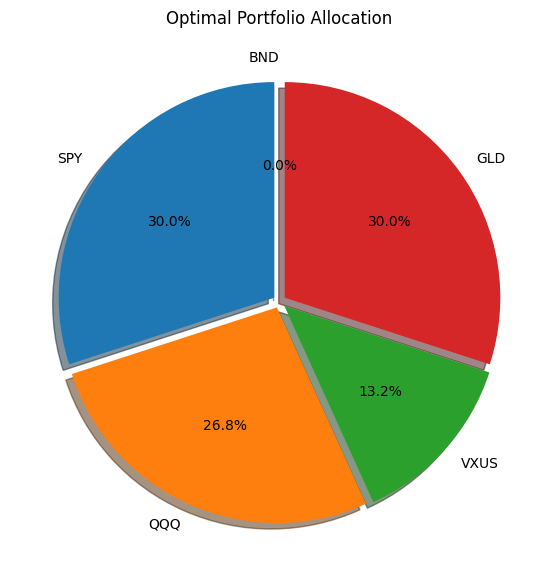

In [67]:
import matplotlib.pyplot as plt

# === Pie Chart for Optimal Portfolio Weights ===
plt.figure(figsize=(7, 7))

# Create the pie chart
plt.pie(
    optimal_weights,              # slice sizes
    labels=tickers,               # asset labels
    autopct='%1.1f%%',            # show percentages
    startangle=90,                # start from top
    explode=[0.03]*len(tickers),  # slightly separate each slice
    shadow=True                   # add depth effect
)

plt.title('Optimal Portfolio Allocation')
plt.show()